In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

import os, re

import claude.utils as cu
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh

In [2]:
seed = 42
tf.set_random_seed(seed)
np.random.seed(seed)

# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M = 16

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.dimension	= 2
aeParam.nLayers		= 2
aeParam.hiddenUnits	= 32
aeParam.activation  = tf.nn.selu
aeParam.dropout		= False
aeParam.dtype       = tf.float32

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.sampleSize	= 512*chParam.M # Increase for better results (especially if M>16)
trainingParam.batchSize 	= 32*chParam.M  # Increase for better results (especially if M>16)
trainingParam.learningRate	= 0.001
trainingParam.displayStep	= 20
trainingParam.path			= 'results_AWGN_noChannel'
trainingParam.filename		= 'M{}'.format(chParam.M)
trainingParam.saveWeights	= True
trainingParam.earlyStopping = 10
trainingParam.tx_iterations = 25
trainingParam.rx_iterations = 25
trainingParam.policy_sigma2 = 0.02

# TF constants
two = tf.constant(2,aeParam.dtype)
minusOne = tf.constant(-1,aeParam.dtype)
DIM = tf.constant(aeParam.dimension,aeParam.dtype)
PI = tf.constant(np.pi,aeParam.dtype)

In [3]:
# Channel Graph
sigma2_noise = tf.constant(0.1,aeParam.dtype)

channel_in = tf.placeholder( aeParam.dtype, shape=(None, aeParam.dimension) )
noise = tf.sqrt( sigma2_noise )\
            *tf.rsqrt(two)\
            *tf.random_normal(shape=tf.shape(channel_in),dtype=aeParam.dtype)

channel_out = channel_in + noise

In [4]:
# Tx Graph     
X = tf.placeholder( aeParam.dtype, shape=(None, chParam.M) )

# enc_seed will hold the most recent M constellation points
X_seed         = tf.constant( np.eye(chParam.M, dtype=int), aeParam.dtype )
enc_seed       = ae.encoder(X_seed,aeParam.hiddenUnits,aeParam.nLayers,aeParam.activation,nOutput=aeParam.dimension)
enc_seed_norm  = cfh.IQ_norm(enc_seed)

enc = ae.encoder(X,aeParam.hiddenUnits,aeParam.nLayers,aeParam.activation,nOutput=aeParam.dimension)
enc_norm = cfh.IQ_norm( enc )

# Tx policy
policy_sigma2 = tf.placeholder( aeParam.dtype, shape=())
perturbation = tf.sqrt( policy_sigma2 ) * tf.rsqrt(two) * tf.random_normal(shape=tf.shape(enc_norm),dtype=aeParam.dtype)
enc_pert = enc_norm + perturbation

In [5]:
# Rx Graph
Y = tf.placeholder( aeParam.dtype, shape=(None, aeParam.dimension) )
dec = ae.decoder(Y,aeParam.hiddenUnits,aeParam.nLayers,aeParam.activation,chParam.M)
per_ex_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=X,logits=dec)

In [6]:
# Rx Loss
correct_prediction = tf.equal(tf.argmax(X,1), tf.argmax(dec,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, aeParam.dtype))
rx_loss = tf.reduce_mean(per_ex_loss)
rx_vars = [item for item in tf.global_variables() if 'decoder' in item.name]
rx_optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate).minimize(rx_loss, var_list=rx_vars)

avg_loss, avg_loss_update, avg_loss_reset = cfh.create_reset_metric(tf.metrics.mean, 'loss_metric', rx_loss)
avg_accuracy, avg_accuracy_update, avg_accuracy_reset = cfh.create_reset_metric(tf.metrics.mean, 'accuracy_metric', accuracy)

In [7]:
# Tx Loss
tx_perturbed = tf.placeholder( aeParam.dtype, shape=(None,aeParam.dimension) )
tx_per_ex_loss  = tf.placeholder( aeParam.dtype, shape=(None,) )
# batch_size = tf.constant(trainingParam.batchSize, aeParam.dtype)
batch_size = tf.placeholder( aeParam.dtype, shape=() )

policy = tf.log( tf.rsqrt( tf.pow(PI*policy_sigma2,DIM) ) * tf.exp( minusOne * tf.square(cfh.IQ_abs( tx_perturbed-enc_norm )) / policy_sigma2 ) )
tx_vars = [item for item in tf.global_variables() if 'encoder' in item.name]

# policy_gradient = tx_optimizer.compute_gradients(policy, var_list=txVars) # eeeeeh, no idea why but I used tf.gradients below
policy_gradient = tf.gradients(policy, tx_vars, grad_ys=tx_per_ex_loss/batch_size) # this here includes the per example loss AND the average

grads_and_vars = [ ( g,v ) for g,v in zip(policy_gradient,tx_vars)]
tx_optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate).apply_gradients(grads_and_vars)
# tx_optimizer = tf.train.GradientDescentOptimizer(learning_rate=trainingParam.learningRate).apply_gradients(grads_and_vars)

In [8]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

saver = tf.train.Saver()
checkpoint_path = os.path.join(trainingParam.path,'checkpoint',trainingParam.filename,'best')
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    pass
#     print("Restoring checkpoint...", flush=True)
#     saver.restore(sess=sess,save_path=checkpoint_path)

In [9]:
def TrainReceiver():
    nBatches = int(trainingParam.sampleSize/trainingParam.batchSize)
    
    bestLoss = 10000
    
    for epoche in range(1, trainingParam.rx_iterations+1):
        sess.run([avg_loss_reset, avg_accuracy_reset])
        for batch in range(0,nBatches):
            data, _, _ = cu.hotOnes(trainingParam.batchSize,(1,0),chParam.M)
            ## GENERATE SYMBOLS
            feedDict = {X: data}
            [outEncNorm, outEncSeedNorm] = sess.run([enc_norm, enc_seed_norm], feed_dict=feedDict)

            ## TRANSMIT THROUGH CHANNEL
            feedDict = {channel_in: outEncNorm}
            outChannelOut = sess.run(channel_out, feed_dict=feedDict)

            ## Train
            feedDict = {X: data,Y:outChannelOut}
            sess.run([rx_optimizer, avg_loss_update, avg_accuracy_update], feed_dict=feedDict)
            
        [outAvgLoss, outAvgAccuracy] = sess.run([avg_loss, avg_accuracy], feed_dict=feedDict)
        
        if outAvgLoss < bestLoss:
            bestLoss = outAvgLoss
            lastImprovement = epoche
            saver.save(sess=sess,save_path=checkpoint_path)
            
        if epoche - lastImprovement > trainingParam.earlyStopping:
            print("Breaking due to no improvement")
            break;
            
        if epoche%trainingParam.displayStep == 0:
            print('rx_epoche: {} - avgLoss: {} - avgAcc: {}'.format(epoche,outAvgLoss,outAvgAccuracy))

In [10]:
def TrainTransmitter(bs):
    nBatches = int(trainingParam.sampleSize/trainingParam.batchSize)
#     nBatches = 1;
    
    
    bestLoss = 10000
    
    for epoche in range(1, trainingParam.tx_iterations+1):
        for batch in range(0,nBatches):
            data, _, _ = cu.hotOnes(trainingParam.batchSize,(1,0),chParam.M,batch)
            ## GENERATE PERTURBED SYMBOLS
            feedDict = {X: data, policy_sigma2: trainingParam.policy_sigma2}
            [outEncPert, outEncSeedNorm] = sess.run([enc_pert, enc_seed_norm], feed_dict=feedDict)

            ## TRANSMIT THROUGH CHANNEL
            feedDict = {channel_in: outEncPert}
            outChannelOut = sess.run(channel_out, feed_dict=feedDict)

            ## PER EXAMPLE LOSS
            feedDict={X:data, Y:outChannelOut}
            outPerExampleLoss = sess.run(per_ex_loss,feed_dict=feedDict)

            ## TRAIN TRANSMITTER
            feedDict={batch_size:bs, X:data,\
                      tx_per_ex_loss: outPerExampleLoss, tx_perturbed: outEncPert, policy_sigma2: trainingParam.policy_sigma2}
            sess.run(tx_optimizer,feed_dict=feedDict)
            
        ## TEST
        sess.run([avg_loss_reset, avg_accuracy_reset])
        for batch in range(0,nBatches):
            data, _, _ = cu.hotOnes(trainingParam.batchSize,(1,0),chParam.M,133700+batch)
            ## GENERATE SYMBOLS
            feedDict = {X: data}
            [outEncNorm, outEncSeedNorm] = sess.run([enc_norm, enc_seed_norm], feed_dict=feedDict)

            ## TRANSMIT THROUGH CHANNEL
            feedDict = {channel_in: outEncNorm}
            outChannelOut = sess.run(channel_out, feed_dict=feedDict)
            
            ## Test
            feedDict = {X: data, Y:outChannelOut}
            sess.run([avg_loss_update, avg_accuracy_update], feed_dict=feedDict)
            
        [outAvgLoss, outAvgAccuracy] = sess.run([avg_loss, avg_accuracy], feed_dict=feedDict)
        
        if outAvgLoss < bestLoss:
            bestLoss = outAvgLoss
            lastImprovement = epoche
            saver.save(sess=sess,save_path=checkpoint_path)
            
        if epoche - lastImprovement > trainingParam.earlyStopping:
            print("Breaking due to no improvement")
            break;
            
        if epoche%trainingParam.displayStep == 0:
            print('tx_epoche: {} - avgLoss: {} - avgAcc: {}'.format(epoche,outAvgLoss,outAvgAccuracy))

In [11]:
for jj in range(1,50):
    print("##### {}".format(jj))
    TrainReceiver()
    saver.restore(sess=sess,save_path=checkpoint_path)
    TrainTransmitter(trainingParam.batchSize*1)
    saver.restore(sess=sess,save_path=checkpoint_path)

##### 1
rx_epoche: 20 - avgLoss: 0.9502663612365723 - avgAcc: 0.6522216796875
INFO:tensorflow:Restoring parameters from results_AWGN_noChannel/checkpoint/M16/best
Breaking due to no improvement
INFO:tensorflow:Restoring parameters from results_AWGN_noChannel/checkpoint/M16/best
##### 2
rx_epoche: 20 - avgLoss: 0.6920173764228821 - avgAcc: 0.725830078125
INFO:tensorflow:Restoring parameters from results_AWGN_noChannel/checkpoint/M16/best
Breaking due to no improvement
INFO:tensorflow:Restoring parameters from results_AWGN_noChannel/checkpoint/M16/best
##### 3
Breaking due to no improvement
INFO:tensorflow:Restoring parameters from results_AWGN_noChannel/checkpoint/M16/best
tx_epoche: 20 - avgLoss: 0.6462141275405884 - avgAcc: 0.756103515625
Breaking due to no improvement
INFO:tensorflow:Restoring parameters from results_AWGN_noChannel/checkpoint/M16/best
##### 4
rx_epoche: 20 - avgLoss: 0.6085070371627808 - avgAcc: 0.7733154296875
Breaking due to no improvement
INFO:tensorflow:Restoring

Breaking due to no improvement
INFO:tensorflow:Restoring parameters from results_AWGN_noChannel/checkpoint/M16/best
##### 29
rx_epoche: 20 - avgLoss: 0.5618846416473389 - avgAcc: 0.785888671875
INFO:tensorflow:Restoring parameters from results_AWGN_noChannel/checkpoint/M16/best
Breaking due to no improvement
INFO:tensorflow:Restoring parameters from results_AWGN_noChannel/checkpoint/M16/best
##### 30
rx_epoche: 20 - avgLoss: 0.5523589253425598 - avgAcc: 0.7933349609375
INFO:tensorflow:Restoring parameters from results_AWGN_noChannel/checkpoint/M16/best
tx_epoche: 20 - avgLoss: 0.54945969581604 - avgAcc: 0.7938232421875
INFO:tensorflow:Restoring parameters from results_AWGN_noChannel/checkpoint/M16/best
##### 31
rx_epoche: 20 - avgLoss: 0.541857898235321 - avgAcc: 0.7945556640625
INFO:tensorflow:Restoring parameters from results_AWGN_noChannel/checkpoint/M16/best
tx_epoche: 20 - avgLoss: 0.5517329573631287 - avgAcc: 0.792236328125
INFO:tensorflow:Restoring parameters from results_AWGN_n

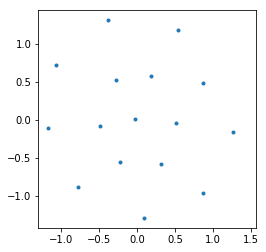

In [12]:
pred_const = sess.run(enc_seed_norm)
plt.plot(pred_const[:,0],pred_const[:,1],'.')
plt.axis('square');